In [95]:
from pathlib import Path
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns

In [27]:
def parse_slide_stats(path):
    entries = []
    with open(path,"r") as f:
        for line in f.readlines():
            entry = {}
            fields = line.split("\t")
            entry["name"] = re.findall("test_(.*)\.",fields[0])[0]
            true_labels= re.findall(r"\[(\d+\.\d+), (\d+\.\d+), (\d+\.\d+)]",fields[1])[0]
            true_labels = [float(x) for x in true_labels]
            pos_label = max(range(len(true_labels)),key=lambda x: true_labels[x])
            entry["pos_label"] = pos_label 
            percent_select = [
                float(re.findall("\d+.\d+",fields[2])[0]),
                float(fields[3]),
                float(fields[4])
            ]
            av_prob = [
                float(re.findall("\d+.\d+",fields[5])[0]),
                float(fields[6]),
                float(fields[7])
            ]
            entry["percent_select"] = percent_select[pos_label]
            entry["av_prob"] = av_prob[pos_label]
            entry["ntiles"] = float(re.findall("\d+.\d+",fields[8])[0])
            entries.append(entry)
    return pd.DataFrame(entries).reset_index(drop=True)

In [28]:
output_dir = Path("work/output/")

## Phase 2 Analyses

In [41]:
phase2_exp = output_dir.glob("phase2_*/")
phase2_slide_results = pd.concat({
    study.stem:parse_slide_stats(study / "auc" / "out2_perSlideStats.txt")
    for study in phase2_exp
},names=["study"]).reset_index()

[Text(0, 0, 'phase2_gender_male'),
 Text(0, 0, 'phase2_race_black'),
 Text(0, 0, 'phase2_race_asian'),
 Text(0, 0, 'phase2_race_white'),
 Text(0, 0, 'phase2_gender_female')]

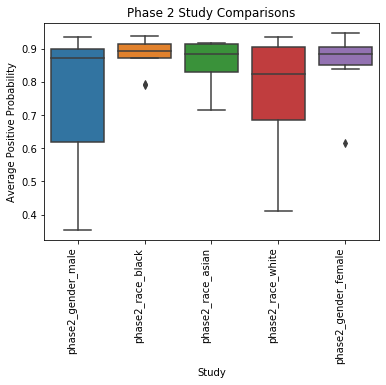

In [100]:
chart = sns.boxplot(x=phase2_slide_results["study"],y=phase2_slide_results["av_prob"])
chart.set_title("Phase 2 Study Comparisons")
chart.set_xlabel("Study")
chart.set_ylabel("Average Positive Probability")
chart.set_xticklabels(chart.get_xticklabels(), rotation=90, horizontalalignment='right')
